# 房价预测  
## House Prices: Advanced Regression Techniques  
从以下几点分析：  
+ 数据可视化和数据分布变换
+ 缺省值处理
+ 数据特征变换
+ 数据建模及交叉检验
+ 模型组合

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

## 1.加载数据

In [2]:
train_path = "./train.csv"
test_path = "./test.csv"
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.数据处理与特征分析

In [3]:
#保存id后去除id
train_ID = train_df['Id']
test_ID = test_df['Id']

#Dropping Ids
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

分析居住面积GrLivArea与房价SalePrice的关系

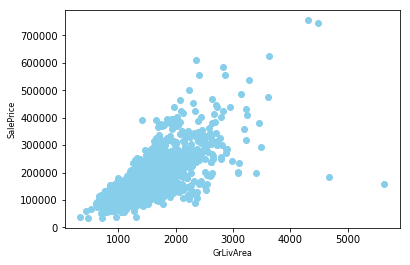

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'], c = "skyblue")
plt.ylabel('SalePrice', fontsize=8)
plt.xlabel('GrLivArea', fontsize=8)
plt.show()

观察上图，GrLivArea有两个点在4000以上，但其价格不到200000，我们将其作为异常值去掉。

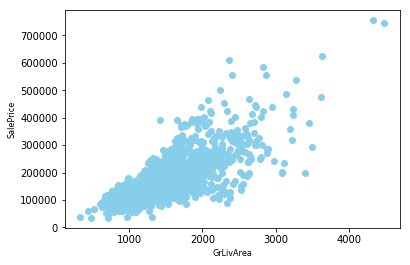

In [5]:
train_df.drop(train_df[(train_df['GrLivArea']>4000)&(train_df['SalePrice']<300000)].index,inplace=True)
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'], c = "skyblue")
plt.ylabel('SalePrice', fontsize=8)
plt.xlabel('GrLivArea', fontsize=8)
plt.show()

观察数据分布

In [6]:
train_df['SalePrice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

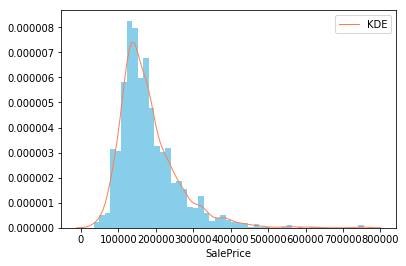

In [7]:
sns.distplot(train_df['SalePrice'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"})

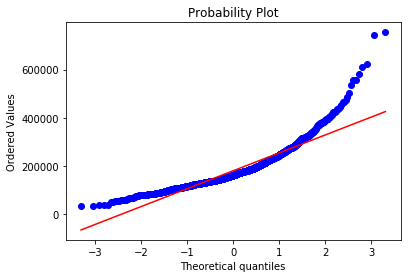

In [8]:
# 绘制P-P图
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], dist="norm", plot=plt)
plt.show()

P-P图是描述数据分布与正态分布之间的关系的，红色线是正态分布，蓝色线是我们的数据，
可以看出，我们的数据头尾都严重偏离了正太分布,我们尝试对数据做变换，
常用的变换有指数变换、对数变换、幂函数等。


Skewness: 0.121580
Kurtosis: 0.804751


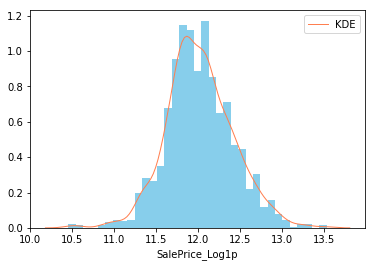

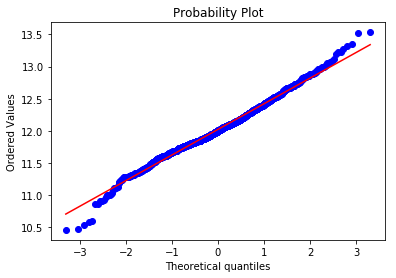

In [9]:
# 对数变换  log1p=log(1+x)
train_df['SalePrice_Log1p'] = np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice_Log1p'], 
             kde_kws={"color": "coral", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});

# 偏度与峰值(skewness and kurtosis)
print("Skewness: %f" % train_df['SalePrice_Log1p'].skew())
print("Kurtosis: %f" % train_df['SalePrice_Log1p'].kurt())

fig = plt.figure()
res = stats.probplot(train_df['SalePrice_Log1p'], plot=plt)
plt.show()

峰值与偏度越接近于0越好，绝对值越大则越远离正态分布。

In [10]:
del train_df["SalePrice"]

In [11]:
size_train_df = train_df.shape[0]
size_test_df = test_df.shape[0]
target_variable = train_df['SalePrice_Log1p'].values
data = pd.concat((train_df, test_df),sort=False).reset_index(drop=True)
data.drop(['SalePrice_Log1p'], axis=1, inplace=True)

## 缺失值处理

In [12]:
data.count().sort_values().head(20)

PoolQC             9
MiscFeature      105
Alley            198
Fence            571
FireplaceQu     1497
LotFrontage     2431
GarageCond      2758
GarageYrBlt     2758
GarageFinish    2758
GarageQual      2758
GarageType      2760
BsmtExposure    2835
BsmtCond        2835
BsmtQual        2836
BsmtFinType2    2837
BsmtFinType1    2838
MasVnrType      2893
MasVnrArea      2894
MSZoning        2913
BsmtFullBath    2915
dtype: int64

Text(0.5, 1.0, 'Percent missing data by feature')

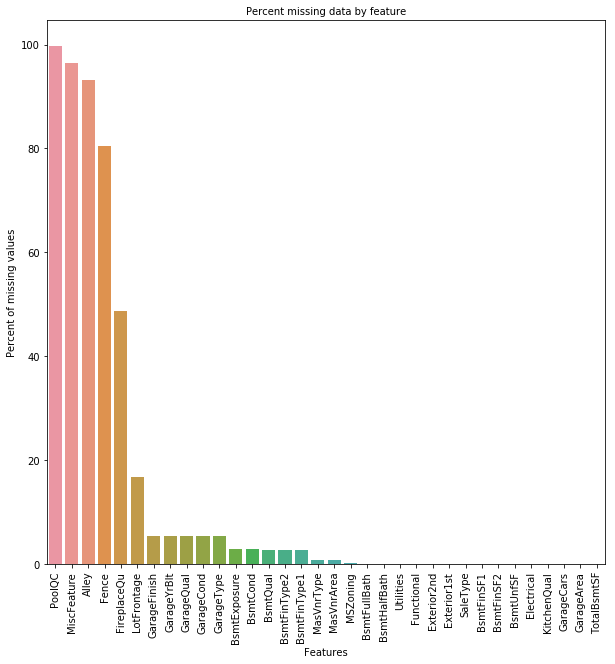

In [13]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na.drop(data_na[data_na==0].index,inplace=True)
data_na = data_na.sort_values(ascending=False)
f, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=10)

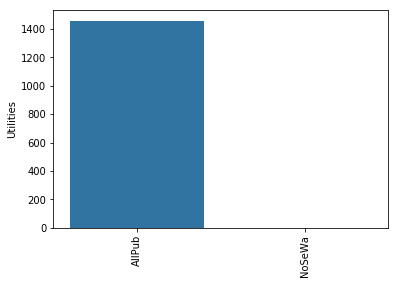

In [14]:
var = 'Utilities'
train_var_count = train_df[var].value_counts()
fig = sns.barplot(x=train_var_count.index, y=train_var_count)
plt.xticks(rotation=90);

In [15]:
# 填充nil
features_fill_na_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MasVnrType']

# 填充0
features_fill_na_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea',
                      'BsmtFullBath','BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 
                      'BsmtUnfSF', 'TotalBsmtSF']

# 填众数
features_fill_na_mode = ["Functional", "MSZoning", "SaleType", "Electrical", 
                         "KitchenQual", "Exterior2nd", "Exterior1st"]

for feature_none in features_fill_na_none:
    data[feature_none].fillna('None',inplace=True)

for feature_0 in features_fill_na_0:
    data[feature_0].fillna(0,inplace=True)

for feature_mode in features_fill_na_mode:
    mode_value = data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    data[features_fill_na_mode] = data[features_fill_na_mode].fillna(mode_value)

# 用中值代替
data["LotFrontage"] = data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# 像 Utilities 这种总共才两个值，同时有一个值是作为主要的，这种字段是无意义的，应该删除
data.drop(['Utilities'], axis=1,inplace=True)

数据类型转换

In [16]:
#MSSubClass=The building class
data['MSSubClass'] = data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
data['OverallCond'] = data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
data['YrSold'] = data['YrSold'].astype(str)
data['MoSold'] = data['MoSold'].astype(str)

## 3.特征工程  
对于类别数据，一般采用LabelEncoder的方式，把每个类别的数据变成数值型；也可以采用one-hot变成稀疏矩阵。
对于数值型的数据，尽量将其变为正态分布

In [17]:
encode_cat_variables = ('Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 
                        'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 
                        'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 
                        'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 
                        'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 
                        'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'YrSold')

numerical_features = [col for col in data.columns if col not in encode_cat_variables]

for variable in data.columns:
    if variable not in encode_cat_variables:
        data[variable] = data[variable].apply(float)
    else:
        data[variable] = data[variable].apply(str)

print(data.shape)

data = pd.get_dummies(data)
print(data.shape)
# 可以计算一个总面积指标
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
print("Categorical Features: %d"%len(encode_cat_variables))
print("Numerical Features: %d"%len(numerical_features))

(2917, 78)
(2917, 343)
Categorical Features: 46
Numerical Features: 32


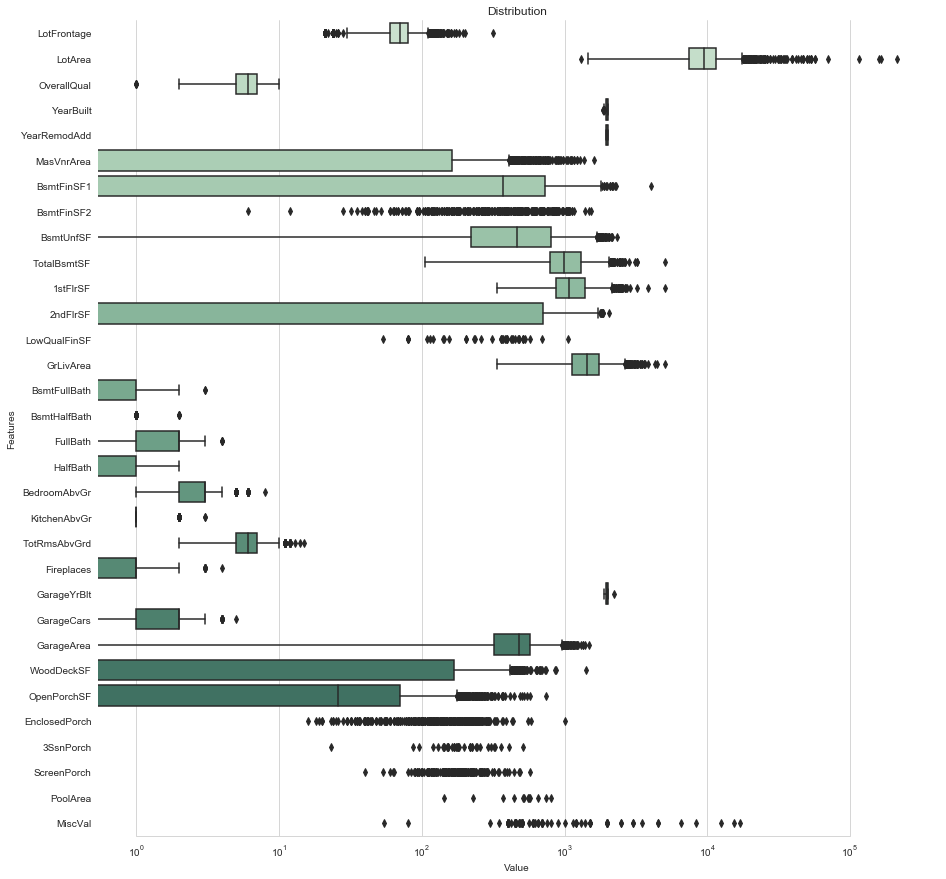

In [18]:
#Boxplot for numerical_features
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
ax.set_xscale("log")
ax = sns.boxplot(data=data[numerical_features] , orient="h", palette="ch:2.5,-.2,dark=.3")
ax.set(ylabel="Features")
ax.set(xlabel="Value")
ax.set(title="Distribution")
sns.despine(trim=True, left=True)

In [19]:
# 计算数值型变量的偏态
skewed_features = data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [20]:
skewed_features = skewed_features[abs(skewed_features) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewed_features.shape[0]))

from scipy.special import boxcox1p
skewed_features_name = skewed_features.index
lam = 0.15 # 超参数
for feat in skewed_features_name:
    tranformer_feat = boxcox1p(data[feat], lam)
    data[feat] = tranformer_feat

data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

There are 20 skewed numerical features to Box Cox transform


PoolArea         15.759529
3SsnPorch         8.921650
LowQualFinSF      8.741030
MiscVal           5.594963
BsmtHalfBath      3.786685
KitchenAbvGr      3.697303
ScreenPorch       2.977052
BsmtFinSF2        2.563235
EnclosedPorch     2.024321
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
MasVnrArea        0.637388
BsmtFullBath      0.622415
2ndFlrSF          0.328879
BedroomAbvGr      0.326568
WoodDeckSF        0.224181
GarageArea        0.216857
OverallQual       0.189591
1stFlrSF          0.179117
LotArea           0.177735
FullBath          0.165514
GrLivArea         0.130051
OpenPorchSF       0.099381
GarageCars       -0.219297
YearRemodAdd     -0.450134
BsmtFinSF1       -0.488866
YearBuilt        -0.599194
LotFrontage      -0.798905
BsmtUnfSF        -1.537286
GarageYrBlt      -3.923748
dtype: float64

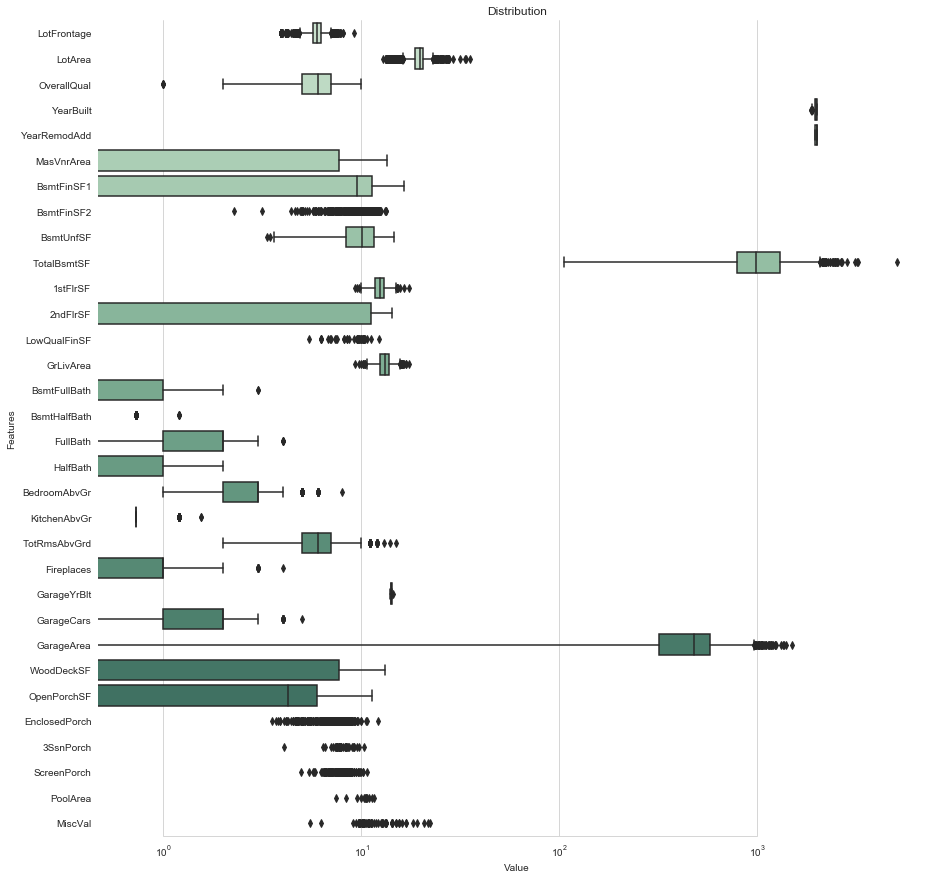

In [21]:
#Boxplot for numerical_features
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 15))
ax.set_xscale("log")
ax = sns.boxplot(data=data[numerical_features] , orient="h", palette="ch:2.5,-.2,dark=.3")
ax.set(ylabel="Features")
ax.set(xlabel="Value")
ax.set(title="Distribution")
sns.despine(trim=True, left=True)

划分数据集

In [22]:
train = data[:size_train_df]
test = data[size_train_df:]

## 4.创建模型

In [23]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

C:\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [24]:
#交叉验证函数
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, target_variable, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

LASSO回归(LASSO Regression)，即加入L1正则化

In [25]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1100 (0.0058)



岭回归（Kernel Ridge Regression），即加入L2正则化

In [26]:
KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))
score = rmsle_cv(KRR)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1153 (0.0044)



弹性网络回归(Elastic Net Regression)，结合了岭回归和Lasso回归，由两者加权平均所得。

In [27]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1100 (0.0060)



提升树(Gradient Boosting Regression)

In [28]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

score = rmsle_cv(GBoost)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1171 (0.0074)



XGBoost

In [29]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[17:22:45] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:22:48] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:22:53] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { silent } might not be used

LightGBM

In [30]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1167 (0.0071)



Text(0, 0.5, 'rmse')

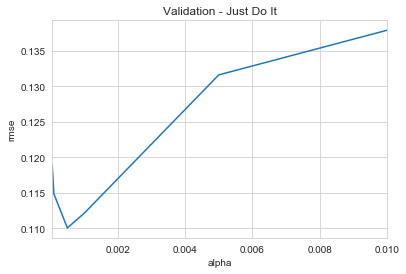

In [31]:
#寻找最优参数
alphas = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
cv_ridge_score = [rmsle_cv(make_pipeline(RobustScaler(), Lasso(alpha=alpha, random_state=1))).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge_score, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

模型测试，绘制残差图

In [32]:
train_size = int(len(train)*0.7)
X_train = train.values[:train_size]
X_test = train.values[train_size:]
y_train = target_variable[:train_size]
y_test = target_variable[train_size:]

GBoost.fit(X_train, y_train)
ENet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

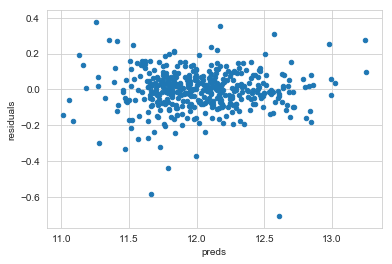

In [33]:
preds = pd.DataFrame({"preds":GBoost.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

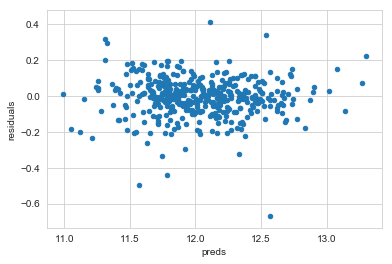

In [34]:
preds = pd.DataFrame({"preds":ENet.predict(X_test), "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

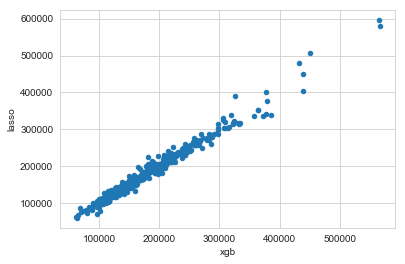

In [35]:
xgb_preds = np.expm1(GBoost.predict(X_test))
lasso_preds = np.expm1(ENet.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

## 5.模型融合

平均模型

In [36]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1082 (0.0056)



堆叠模型：其由两部分组成，一部分是基准模型，一部分是回归模型。
基准模型和大量数据组合预测一堆结果，然后根据预测结果通过回归模型预测和真实值的差异
![avatar](https://pic4.zhimg.com/80/v2-7c03c1848e103bd26df85e853eaeb0c3_1440w.jpg)

In [37]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model) # 复制基准模型，因为这里会有多个模型
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # 训练基准模型，基于基准模型训练的结果导出成特征
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y): #分为预测和训练
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # 将基准模型预测数据作为特征用来给meta_model训练
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
from sklearn.linear_model import LinearRegression
meta_model = LinearRegression()
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR, lasso),
                                                 meta_model = meta_model,
                                                n_folds=10)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1087 (0.0060)


## 6.测试集预测结果并保存

In [38]:
averaged_models.fit(train, target_variable)
predictions = averaged_models.predict(test)
Id =np.array(test_ID).astype(int)

#注意预测值通过np.expm1还原，因为预测值初始通过np.log1p处理过
my_prediction = pd.DataFrame({'Id':Id, 'SalePrice':np.expm1(predictions)})
my_prediction.to_csv("my_prediction.csv", index=False)